In [295]:
import pandas as pd
import numpy as np
import xlrd
import os

In [296]:
def findfile(dirpath,filename):
    list_dirs = os.listdir(dirpath)
    fileindex = filename in list_dirs and list_dirs.index(filename)
    return "{}{}".format(dirpath,list_dirs[fileindex])

def gettables(filepath):
    wb = xlrd.open_workbook(filepath)
    sheets = wb.sheet_names()
    tables = [pd.read_excel(excel_name, sheet_name=sheet,skiprows=1) for sheet in sheets]
    return {'table_names':sheets,'tables':tables}

def check_the_same(obj1,obj2):
    sheet1 = np.array(obj1)
    sheet2 = np.array(obj2)
    shape1,shape2 = np.array(sheet1.shape),np.array(sheet2.shape)
    if (shape1==shape2)[0]:
        return np.dot(sheet1-sheet5,np.ones(sheet1.shape[0]))==0
    else:
        return 'series have different lengths'
    
def checkdiff(obj1,obj2):
    element1,element2 = np.array(obj1).astype(int),np.array(obj2).astype(int)
    test = np.setxor1d(element1,element2)
    find_xorld = lambda element: np.where(element==test)
    return {'diff':test,"1":find_xorld(element1),"2":find_xorld(element2)[0]}


In [297]:
dirpath = '/Users/manmanzhang/Downloads/'
filename = '初试成绩0527.xlsx'
open_tables = gettables(findfile(dirpath,filename))
open_tables['table_names']
obj1 ,obj2_0 = open_tables['tables'][0].面试号 ,open_tables['tables'][1].抽签号
obj2 = obj2_0[obj2_0 != '未抽号']
if check_the_same(obj1,obj2) == 'series have different lengths':
    print(checkdiff(obj1,obj2),)
table1,table2= open_tables['tables'][0], open_tables['tables'][1]

{'diff': array([65]), '1': (array([], dtype=int64),), '2': array([59])}


In [298]:
table2['抽签号']=table2['抽签号'].apply(lambda x : x == '未抽号' and np.inf or int(str(x).replace('0','')))
table2.rename(columns={'抽签号':'面试号'},inplace=True) 

In [299]:
result = pd.merge(table1,table2, how='outer',on=['面试号'])
result.shape

/usr/local/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1108: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,


(96, 18)

In [300]:
result.columns

Index(['序号_x', '面试号', '姓名_x', '准考证号_x', '1号面试官打分（王）', '2号面试官打分', '3号面试官打分（马）',
       '4号面试官打分', '5号面试官打分', '总分', '平均分', '备注_x', '序号_y', '姓名_y', '准考证号_y',
       '面试时间', '签到', '备注_y'],
      dtype='object')

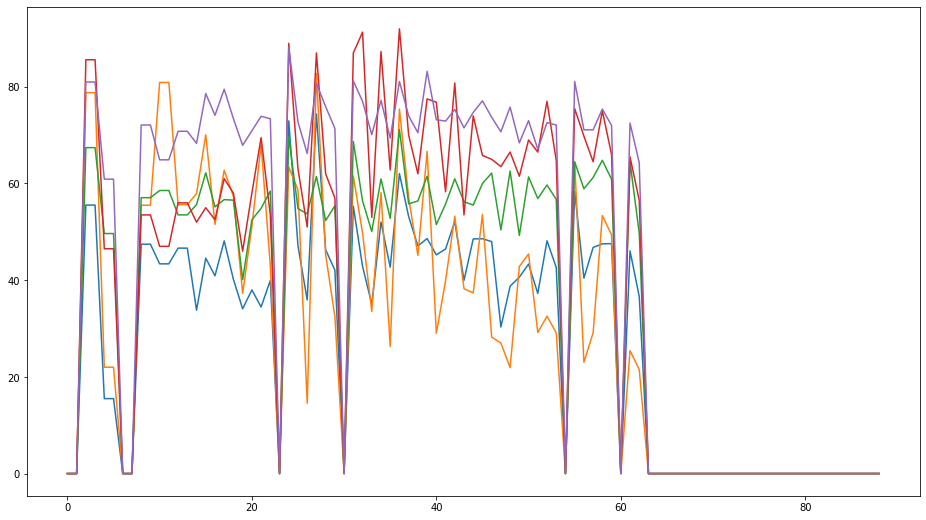

In [301]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,9))
for i in result.columns[4:9]:
    plt.plot(result[i])
plt.show()

In [302]:
stats_table = result[['姓名_y']+list(result.columns[4:9])]
stats_table.columns

Index(['姓名_y', '1号面试官打分（王）', '2号面试官打分', '3号面试官打分（马）', '4号面试官打分', '5号面试官打分'], dtype='object')

In [338]:
dict_stats = pd.DataFrame({i:[np.std(np.array(stats_table[i])[:63])
    ,np.mean(np.array(stats_table[i])[:63])
    ,np.median(np.array(stats_table[i])[:63])
    ,np.argmax(np.array(stats_table[i])[:63])
    ,np.max(np.array(stats_table[i])[:63])
    ,np.min(np.array(stats_table[i])[:63][np.array(stats_table[i])[:63]!=0])
      ]
 for i in stats_table.columns[1:]}).T
dict_stats.columns = ['标准差','均值','中位数','众数','最大值','最小值']
dict_stats

,标准差,均值,中位数,众数,最大值,最小值
1号面试官打分（王）,17.633000,39.076190,43.38,27.0,74.39,15.50
2号面试官打分,23.167943,41.728730,45.11,27.0,82.78,14.55
3号面试官打分（马）,19.935774,50.304921,56.39,36.0,71.18,40.12
4号面试官打分,24.761297,56.990476,62.00,36.0,92.00,46.00
5号面试官打分,24.871828,63.869841,72.10,24.0,88.20,60.90


In [358]:
from sklearn import svm

In [597]:
x = stats_table[['1号面试官打分（王）','2号面试官打分','3号面试官打分（马）','4号面试官打分','5号面试官打分']].dropna(axis=0,how='all')
print(x.shape)
xsrc = np.array(x)
xindex = np.dot(x!=0,np.ones(5))>1
x = xsrc[xindex]
xstats = stats_table[['1号面试官打分（王）', '2号面试官打分', '3号面试官打分（马）', '4号面试官打分', '5号面试官打分']].dropna(axis=0,how='all')[xindex]
x.shape,xstats.shape


(89, 5)


((55, 5), (55, 5))

In [598]:
#异常检测
model_onecalsssvm = svm.OneClassSVM(nu=0.1, kernel="rbf", random_state=0) # 创建异常检测算法模型对象
model_onecalsssvm.fit(x) # 训练模型
pre_test_outliers = model_onecalsssvm.predict(x) # 异常检测

/usr/local/lib/python3.7/site-packages/sklearn/svm/classes.py:1194: DeprecationWarning: The random_state parameter is deprecated and will be removed in version 0.22.
  " be removed in version 0.22.", DeprecationWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [613]:
# 异常结果统计
toal_test_data = np.hstack((x[:,:2], pre_test_outliers.reshape(x[:,:2].shape[0], 1))) # 将测试集和检测结果合并
normal_test_data = toal_test_data[toal_test_data[:, -1] == 1] # 获得异常检测结果中集
outlier_test_data = toal_test_data[toal_test_data[:, -1] == -1] # 获得异常检测结果异常数据
n_test_outliers = outlier_test_data.shape[1] # 获得异常的结果数量
total_count_test = toal_test_data.shape[0] # 获得测试集样本量
print ('outliers: {0}/{1}'.format(n_test_outliers, total_count_test)) # 输出异常的结果数量
print ('{:*^60}'.format(' all result data (limit) ')) # 打印标题
print (toal_test_data.shape) # 打印输出前5条合并后的数据集

outliers: 3/55
***************** all result data (limit) ******************
(55, 3)


In [616]:
toal_index = [i for i in xstats[toal_test_data[:,-1]>0].index]
[np.array(stats_table[i-1:i]) for i in toal_index]

[array([['余甜甜', 0.0, 0.0, 0.0, 0.0, 0.0]], dtype=object),
 array([['马丽华', 55.54, 78.8, 67.42, 85.6, 81.0]], dtype=object),
 array([['薛雨', 33.8, 57.89, 55.64, 52.0, 68.3]], dtype=object),
 array([['权宇', 48.13, 62.75, 56.67, 61.0, 79.5]], dtype=object),
 array([['高瑶', 37.99, 51.07, 52.48, 58.0, 70.9]], dtype=object),
 array([['夏小云', 72.95, 63.39, 69.67, 89.0, 88.2]], dtype=object),
 array([['李瀚洋', 35.92, 14.55, 53.71, 51.0, 66.2]], dtype=object),
 array([['刘静', 0.0, 0.0, 0.0, 0.0, 0.0]], dtype=object),
 array([['岳翠萍', 35.02, 33.55, 50.07, 53.0, 70.1]], dtype=object),
 array([['杨姝颖', 42.69, 26.26, 52.77, 62.8, 69.4]], dtype=object),
 array([['魏盛', 53.16, 57.05, 55.79, 70.0, 74.0]], dtype=object),
 array([['何文英', 47.09, 45.11, 56.39, 62.0, 70.5]], dtype=object),
 array([['高珊', 45.24, 29.01, 51.5, 76.8, 73.2]], dtype=object),
 array([[nan, 48.53, 37.37, 55.53, 74.0, 74.7]], dtype=object),
 array([['陈东梅', 40.62, 42.83, 49.27, 61.5, 68.4]], dtype=object),
 array([['周玉茹', 40.42, 23.01, 58.9, 6

In [615]:
x.shape

(55, 5)

In [473]:
# mini-batch k均值聚类
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import  KMeans


In [483]:
# 定义模型
model =  KMeans(n_clusters=10,init='k-means++').fit(x)
# 模型拟合
# 为每个示例分配一个集群
newdata = np.c_[model.labels_,np.array(x)]
slice_ = [np.squeeze((newdata==i)[:,0:1]) for i in range(10)]

In [484]:
[x[i] for i in slice_]

[array([[34.08, 37.26, 40.12, 46.  , 67.9 ],
        [35.92, 14.55, 53.71, 51.  , 66.2 ],
        [35.02, 33.55, 50.07, 53.  , 70.1 ],
        [30.31, 27.  , 50.4 , 63.5 , 70.7 ],
        [36.62, 21.51, 49.73, 56.5 , 64.3 ]]),
 array([[55.54, 78.8 , 67.42, 85.6 , 81.  ],
        [55.54, 78.8 , 67.42, 85.6 , 81.  ],
        [72.95, 63.39, 69.67, 89.  , 88.2 ],
        [74.39, 82.78, 61.45, 87.  , 80.7 ],
        [62.04, 75.39, 71.18, 92.  , 81.1 ]]),
 array([[44.56, 70.07, 62.22, 55.  , 78.6 ],
        [48.13, 62.75, 56.67, 61.  , 79.5 ],
        [34.46, 68.05, 54.86, 69.5 , 73.9 ]]),
 array([[53.16, 57.05, 55.79, 70.  , 74.  ],
        [48.53, 37.37, 55.53, 74.  , 74.7 ],
        [48.57, 53.59, 60.01, 65.8 , 77.1 ],
        [43.33, 45.42, 61.37, 69.  , 73.  ],
        [47.52, 53.38, 64.8 , 75.  , 75.4 ],
        [47.56, 49.36, 60.87, 66.  , 72.  ]]),
 array([[39.93, 43.01, 58.44, 53.5 , 73.4 ],
        [46.28, 45.25, 52.33, 62.  , 75.9 ],
        [42.08, 32.5 , 55.39, 57.  , 71.4 ],
  

In [509]:
mean_data = (x[:,0]+x[:,1]+x[:,2]+x[:,3]+x[:,4])/5
np.std(mean_data-x[:,0]),np.std(mean_data-x[:,1]),np.std(mean_data-x[:,2]),np.std(mean_data-x[:,3]),np.std(mean_data-x[:,4])

(4.631970292943464,
 12.396026697252966,
 5.302530441743812,
 7.931134624445255,
 4.683509841035288)

array([78.8 , 78.8 , 22.  , 22.  , 55.5 , 55.5 , 80.9 , 80.9 , 55.63,
       55.63, 57.89, 70.07, 51.53, 62.75, 57.33, 37.26, 51.07, 68.05,
       43.01, 63.39, 58.66, 14.55, 82.78, 45.25, 32.5 , 61.55, 49.73,
       33.55, 58.13, 26.26, 75.39, 57.05, 45.11, 66.65, 29.01, 39.89,
       53.24, 38.23, 37.37, 53.59, 28.22, 27.  , 21.91, 42.83, 45.42,
       29.19, 32.56, 29.12, 64.35, 23.01, 29.12, 53.38, 49.36, 25.43,
       21.51])

In [518]:
# 定义模型
class_n = 6
model =  KMeans(n_clusters=class_n,init='k-means++').fit(x)
# 模型拟合
# 为每个示例分配一个集群
newdata = np.c_[model.labels_,np.array(x[:,1])]
slice_2 = [np.squeeze((newdata==i)[:,0:1]) for i in range(class_n)]
[[np.std(j) for j in x[i]] for i in slice_2]

[[17.265526345871994,
  17.265526345871994,
  12.069403299252206,
  17.71063025417221,
  13.374395537743004,
  17.40405975627526,
  15.142247389340856],
 [10.863977908666786,
  10.863977908666786,
  10.238776098733675,
  8.892294641992018,
  9.999112760640315],
 [8.168727195836567,
  8.168727195836567,
  7.897504922442276,
  7.897504922442276,
  11.25369557078918,
  10.787078195693214,
  10.27460753508376,
  10.524431386065475,
  10.665708415290569,
  14.330771926173414,
  11.953885728080223,
  8.523197522057085,
  11.444651851410773,
  9.424910397452061,
  11.248931327019472,
  12.122282623334602,
  9.926148497780996,
  10.759956505488304,
  12.082411348733332,
  9.43583891341941],
 [13.3489858790846,
  15.243512193717038,
  17.82893827461411,
  14.534547258170791,
  15.914903706903164,
  19.81404693645395,
  15.475598082142092,
  16.256871039655817,
  15.461615698238006,
  18.448251516065145,
  14.999162109931339,
  17.088584025600248],
 [13.435715983899037, 13.435715983899037, 11.78

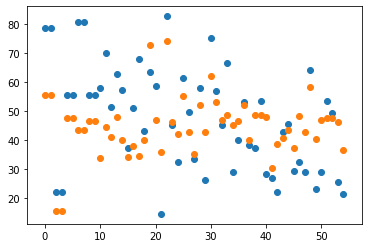

In [521]:
plt.scatter(range(x[:,1].shape[0]),x[:,1])
plt.scatter(range(x[:,0].shape[0]),x[:,0])

In [638]:
(x[:,2]-x[:,2].mean()>0).sum()

24